In [ ]:
##!/usr/bin/env python
"""plot_LCZ_contrast.py

Script plots the KDEs for each LCZ of the urban nested domain:
d02: 800m resolution with urban LCZs

Author: Annette L Hirsch @ CLEX, UNSW. Sydney (Australia)
email: a.hirsch@unsw.edu.au
Created: Thu Jul 30 14:26:12 AEST 2020

"""

    LCZ1 = Compact high-rise
    LCZ2 = Compact midrise
    LCZ3 = Compact lowrise
    LCZ4 = Open high-rise
    LCZ5 = Open mid-rise
    LCZ6 = Open low-rise
    LCZ7 = lightweight low-rise
    LCZ8 = Large low-rise
    LCZ9 = Sparsely built
    LCZ10 = heavy industry

In [1]:
import warnings
warnings.filterwarnings("ignore")

Load Packages

In [2]:
#from __future__ import division
import numpy as np
import pandas as pd
import math
import netCDF4 as nc
import sys
import os
import glob as glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
from matplotlib import cm
from matplotlib.collections import LineCollection
import common_functions as cf
import datetime as dt
import wrf
from scipy import stats


## Model Data

In [3]:
# Simulation Period
syear = 2017
smon = 1
sday = 2 
eyear = 2017
emon = 2
eday = 28  # Add an extra day so that the 27th Feb data is included
simlen = dt.datetime(eyear,emon,eday) - dt.datetime(syear,smon,sday)
nst = (simlen.days * 24 * 6) # No. simulations days x 24 hours in a day x 6 history intervals per hour

# Dates - Used for subsetting the AWS data so you pick the day before the start date and the day after the end date
sdate = "2017-01-01"
edate = "2017-02-28"

# Data directory 
datadir='/g/data/w97/azh561/WRF/'
ensmem = ['sydney800m','sydney800m_06H','sydney800m_12H','sydney800m_18H','sydney800m_00H']
rlabels = ['U1','U2','U3','U4','U5']
domain = "d02" #"d02"
nmem = len(ensmem)

# Landsea mask
mask_file='/g/data/w97/azh561/WRF/sydney800m/geo_em.%s.nc' %('d02')
f = nc.Dataset(mask_file)
lu = f.variables['LU_INDEX'][0,:,:]
luf = f.variables['LANDUSEF'][0,:,:,:]
lat2d = f.variables['XLAT_M'][0,:,:]
lontmp = f.variables['XLONG_M'][0,:,:]
lon2d = np.where(lontmp<0.0,lontmp+360,lontmp)
clon = f.getncattr('CEN_LON')
nlu = f.getncattr('NUM_LAND_CAT')
iswater = f.getncattr('ISWATER')
f.close()

# LCZs
#LCZnm = ['Compact high-rise','Compact midrise','Compact low-rise','Open high-rise',
#         'Open low-rise','Lightweight low-rise','Large low-rise','Sparsely built','Heavy industry']
LCZnm = ['Compact high-rise','Compact midrise','Compact low-rise','Open high-rise',
         'Open low-rise','Large low-rise','Sparsely built','Heavy industry']

# Figure Details
fig_dir='%s/figures/' %(os.getcwd())
fig_name_prefix='LCZ_'
if not os.path.exists(fig_dir):
  os.makedirs(fig_dir)


In [4]:
start = dt.datetime(syear,smon,sday,0,0,0)
end = dt.datetime(eyear,emon,eday,0,0,0)
days = (end - start).days
ntim = days * 24 * 60
datelist = [start + dt.timedelta(minutes=x) for x in range(ntim+1)]
# Get the day-month hour-minutes on 10 minute interval
ftimes = np.asarray([datelist[x].strftime("%m-%d %H-%M") for x in range(ntim+1)])[::10]
fhours = np.asarray([datelist[x].strftime("%H") for x in range(ntim+1)])[::10]

## Extract LCZ grid cell locations where they are dominant (f > 50%)

In [5]:
fthres = 0.50

LCZ1 = list(np.where(luf[30,:,:].flatten() >= fthres)[0]) # 6
LCZ2 = list(np.where(luf[31,:,:].flatten() >= fthres)[0]) # 4
LCZ3 = list(np.where(luf[32,:,:].flatten() >= 0.75)[0]) # 129 f = 0.5 -> 286
LCZ4 = list(np.where(luf[33,:,:].flatten() >= fthres)[0]) # 4
LCZ6 = list(np.where(luf[35,:,:].flatten() >= 0.99)[0]) # 1150 f = 0.5 ->2444
LCZ7 = list(np.where(luf[36,:,:].flatten() >= fthres)[0]) # 63
LCZ8 = list(np.where(luf[37,:,:].flatten() >= fthres)[0]) # 136
LCZ9 = list(np.where(luf[38,:,:].flatten() >= 0.99)[0]) # 846 f = 0.5 ->1668
LCZ10 = list(np.where(luf[39,:,:].flatten() >= fthres)[0]) # 15

# INclude the grass and forested PFTs to provide contrast

grasses = luf[9,:,:]+luf[11,:,:] # grass and crops
forests = luf[0,:,:]+luf[1,:,:] # ENF and EBF

GRASS = list(np.where(grasses.flatten() >= fthres)[0]) # 32584
TREE = list(np.where(forests.flatten() >= fthres)[0]) # 46904

nluind = [len(LCZ1),len(LCZ2),len(LCZ3),len(LCZ4),len(LCZ6),len(LCZ7),len(LCZ8),len(LCZ9),len(LCZ10)]

print(nluind)


[6, 4, 129, 4, 1150, 63, 136, 846, 15]


Amalgamate the LCZs into single array

In [6]:
luind = [30,31,32,33,35,36,37,38,39]
thres = [0.5,0.5,0.75,0.5,0.99,0.5,0.5,0.99,0.5,0.99,0.99]

# Loop through the LCZs to get the relevant grid cells
for ll in range(9): 

    if ll < 10:
        LCZind = np.where(luf[luind[ll],:,:] >= thres[ll])
    elif ll == 10:
        LCZind = np.where((luf[9,:,:]+luf[11,:,:]) >= thres[ll])
    elif ll == 11:
        LCZind = np.where((luf[0,:,:]+luf[1,:,:]) >= thres[ll])

    if ll == 0:
        slat = list(LCZind[0][:])
        slon = list(LCZind[1][:])
    else:
        slat = np.append(slat,list(LCZind[0][:]))
        slon = np.append(slon,list(LCZind[1][:]))
        
    del LCZind

In [7]:
lind = [6,10,139,143,1293,1356,1492,2338,2353]
nLCZ = len(lind)
LCZind = np.empty((len(slat)),dtype=np.float64)
llcounter = 0
for ll in [1,2,3,4,6,7,8,9,10]:
    if ll == 1:
        LCZind[:lind[llcounter]] = ll
    elif ll == 10:
        LCZind[lind[llcounter-1]:] = ll
    else:
        LCZind[lind[llcounter-1]:lind[llcounter]] = ll
    llcounter = llcounter +1

## Extract model data corresponding to each of the LCZs
    takes 40 mins per ensemble member for the 2 months of simulation
    

In [ ]:
for mm in range(nmem):

    tsdata = np.empty((4,len(ftimes)-1,len(slat)),dtype=np.float64) # [nvar,ntime, nlat,nlon] (4, 8209, nLCZpts)
    
    # Files list
    filelist = sorted(glob.glob('%s/%s/WRF_output/%s/wrfout_%s_2017-*' %(datadir,ensmem[mm],domain,domain)))
    nfile = len(filelist)
    for ff in range(int(nfile/24)):

        wrffiles = [nc.Dataset(filelist[(ff*24)],'r'),nc.Dataset(filelist[(ff*24)+1],'r'),nc.Dataset(filelist[(ff*24)+2],'r')
        ,nc.Dataset(filelist[(ff*24)+3],'r'),nc.Dataset(filelist[(ff*24)+4],'r'),nc.Dataset(filelist[(ff*24)+5],'r')
        ,nc.Dataset(filelist[(ff*24)+6],'r'),nc.Dataset(filelist[(ff*24)+7],'r'),nc.Dataset(filelist[(ff*24)+8],'r')
        ,nc.Dataset(filelist[(ff*24)+9],'r'),nc.Dataset(filelist[(ff*24)+10],'r'),nc.Dataset(filelist[(ff*24)+11],'r')
        ,nc.Dataset(filelist[(ff*24)+12],'r'),nc.Dataset(filelist[(ff*24)+13],'r'),nc.Dataset(filelist[(ff*24)+14],'r')
        ,nc.Dataset(filelist[(ff*24)+15],'r'),nc.Dataset(filelist[(ff*24)+16],'r'),nc.Dataset(filelist[(ff*24)+17],'r')
        ,nc.Dataset(filelist[(ff*24)+18],'r'),nc.Dataset(filelist[(ff*24)+19],'r'),nc.Dataset(filelist[(ff*24)+20],'r')
        ,nc.Dataset(filelist[(ff*24)+21],'r'),nc.Dataset(filelist[(ff*24)+22],'r'),nc.Dataset(filelist[(ff*24)+23],'r')]

        rh2  = wrf.getvar(wrffiles,"rh2",timeidx=None,method='cat')[:,slat,slon]
        td2  = wrf.getvar(wrffiles,"td2",units='degC',timeidx=None,method='cat')[:,slat,slon]
        t2   = wrf.getvar(wrffiles,'T2',timeidx=None,method='cat')[:,slat,slon] - 273.15
        wnd = wrf.getvar(wrffiles,"wspd_wdir10",units='km h-1',timeidx=None,method='cat')[0,:,slat,slon]

        for ss in range(len(slat)):
            tsdata[0,144*ff:144*(ff+1),ss] = t2[:144,ss,ss]
            tsdata[1,144*ff:144*(ff+1),ss] = td2[:144,ss,ss]
            tsdata[2,144*ff:144*(ff+1),ss] = rh2[:144,ss,ss]
            tsdata[3,144*ff:144*(ff+1),ss] = wnd[:144,ss,ss]
            
        # Cleanup
        for a in range(24):
            wrffiles[a].close()
        del wrffiles,t2,td2,rh2,wnd
        
    del filelist,nfile
    
    # Write output to file
        
    dataset = nc.Dataset('/g/data/w97/azh561/WRF/processed/wrfout_LCZs_%s_%s.nc' %(ensmem[mm],domain),'w') # open file

    # Create dimensions
    time = dataset.createDimension('time',(len(ftimes)-1))
    pts = dataset.createDimension('pts',len(slat))

    # Create coordinate variables
    times = dataset.createVariable('time',ftimes.dtype,('time',))
    LCZs = dataset.createVariable('pts',np.float64,('pts',))

    # Create variables
    T2 = dataset.createVariable('T2', np.float64,('time','pts'))
    TD2 = dataset.createVariable('TD2', np.float64,('time','pts'))
    RH2 = dataset.createVariable('RH2', np.float64,('time','pts'))
    WND = dataset.createVariable('WND', np.float64,('time','pts'))

    # Write data
    T2[:] = tsdata[0,:,:] 
    TD2[:] = tsdata[1,:,:]  
    RH2[:] = tsdata[2,:,:]  
    WND[:] = tsdata[3,:,:]  
    times[:] = ftimes[:-1]
    LCZs[:] = LCZind[:]

    # Write the file
    dataset.close()
    

### Read in the extracted data and plot
- calculate the ensemble average on Gadi using ncea

In [8]:
# Get urban
tsdata = np.empty((4,len(ftimes)-1,len(slat)),dtype=np.float64)
file = nc.Dataset('/g/data/w97/azh561/WRF/processed/wrfout_LCZs_%s.nc' %('d02'),'r')
tsdata[0,:,:] = file.variables['T2'][:,:]
tsdata[1,:,:] = file.variables['TD2'][:,:]
tsdata[2,:,:] = file.variables['RH2'][:,:]
tsdata[3,:,:] = file.variables['WND'][:,:]
file.close()

# Get grass
gdata = np.empty((4,len(ftimes)-1,len(slat)),dtype=np.float64)
file = nc.Dataset('/g/data/w97/azh561/WRF/processed/wrfout_LCZs_%s.nc' %('d03'),'r')
gdata[0,:,:] = file.variables['T2'][:,:]
gdata[1,:,:] = file.variables['TD2'][:,:]
gdata[2,:,:] = file.variables['RH2'][:,:]
gdata[3,:,:] = file.variables['WND'][:,:]
file.close()

# Plot the KDEs

In [9]:
# Function to plot data
def plot_kde(mdata,vlabels,luind,LCZnm,figurename,mx,mn):
    """This function plots separate panels for each model 
    """
    import seaborn as sns; sns.set(style="white", color_codes=True)
    import string

    # Define dimensions
    nLCZ = len(luind)
    nvar = mdata.shape[0]
    npts = mdata.shape[1]
      
    # Create figure object and subplots
    fig, ax = plt.subplots(1, 4, figsize=(20,5), squeeze=False)
    
    plt.rcParams['savefig.dpi'] = 500
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["axes.titleweight"] = "bold"
    plt.rcParams["axes.titlepad"] = -12.0
    
    # Define the line styles and colors for the datasets
    r = [0,0,0,0]
    c = [0,1,2,3]    
    evenly_spaced_interval = np.linspace(0, 1, nLCZ)
    mycolors = [plt.cm.rainbow(x) for x in evenly_spaced_interval]
        
    # Loop through the variables
    for vv in range(nvar):        
        
        # Loop through the model
        for ll in range(nLCZ):
            if ll == 0:
                tmpdata = mdata[vv,:,:luind[ll]]
                lcount = np.count_nonzero(~np.isnan(mdata[0,0,:luind[ll]]))
                LCZlb = '%s (%s)' %(LCZnm[ll],lcount)
            elif ll == nLCZ-1:
                tmpdata = mdata[vv,:,luind[ll-1]:]
                lcount = np.count_nonzero(~np.isnan(mdata[0,0,luind[ll-1]:]))
                LCZlb = '%s (%s)' %(LCZnm[ll],lcount)
            else:
                tmpdata = mdata[vv,:,luind[ll-1]:luind[ll]]
                lcount = np.count_nonzero(~np.isnan(mdata[0,0,luind[ll-1]:luind[ll]]))
                LCZlb = '%s (%s)' %(LCZnm[ll],lcount)
            sns.kdeplot(tmpdata.flatten(), ax=ax[r[vv],c[vv]], shade=False, color=mycolors[ll], 
                        linestyle='-',linewidth=2,label=LCZlb,legend=False)
            del tmpdata

        # Labelling of subplot panels
        ax[r[vv],c[vv]].set_xlim(mn[vv],mx[vv])
        ax[r[vv],c[vv]].set_xlabel('%s' %(vlabels[vv]), fontweight = 'bold')
        ax[r[vv],c[vv]].set_ylabel("Density Function")
        ax[r[vv],c[vv]].set_title('(%s)' %(string.ascii_lowercase[vind]), fontweight='bold', fontsize=20, y = 0.9, x = 0.025)


    legend = ax[-1,1].legend(loc='upper center', bbox_to_anchor=(1.05,-0.15), ncol=5, fontsize=14)
    fig.subplots_adjust(wspace=0.30, hspace=0)
    fig.savefig(figurename,bbox_extra_artists=(legend,), bbox_inches='tight')
#    plt.close(fig)


#### Plot LCZ distributions for all grid cells

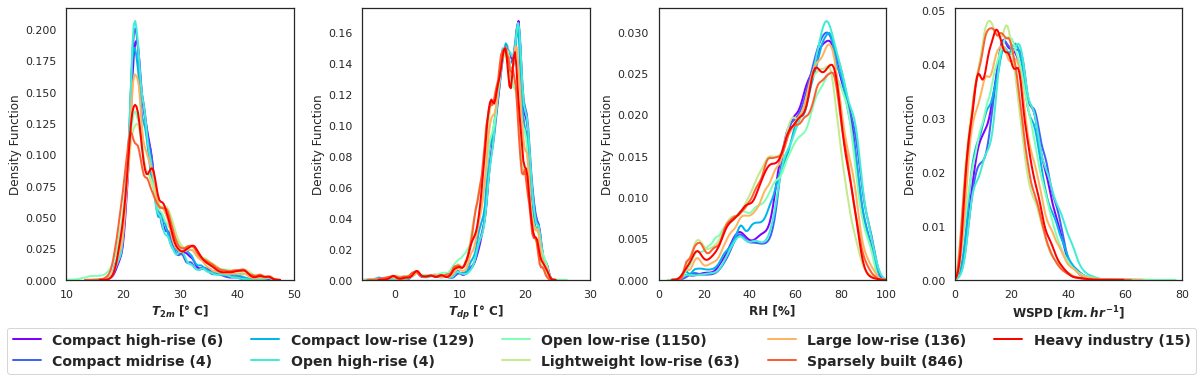

In [10]:
lind = [6,10,139,143,1293,1356,1492,2338,2353]
vlabels = ['$T_{2m}$ [\xb0 C]','$T_{dp}$ [\xb0 C]', 'RH [%]','WSPD [$km.hr^{-1}$]']
mx = [50,30,100,80]
mn = [10,-5,0,0]
figurename = 'KDE_LCZs_Sydney_All.png' 
plot_kde(tsdata,vlabels,lind,LCZnm,figurename,mx,mn)

#### Plot LCZ distributions for coastal grid cells near the CBD

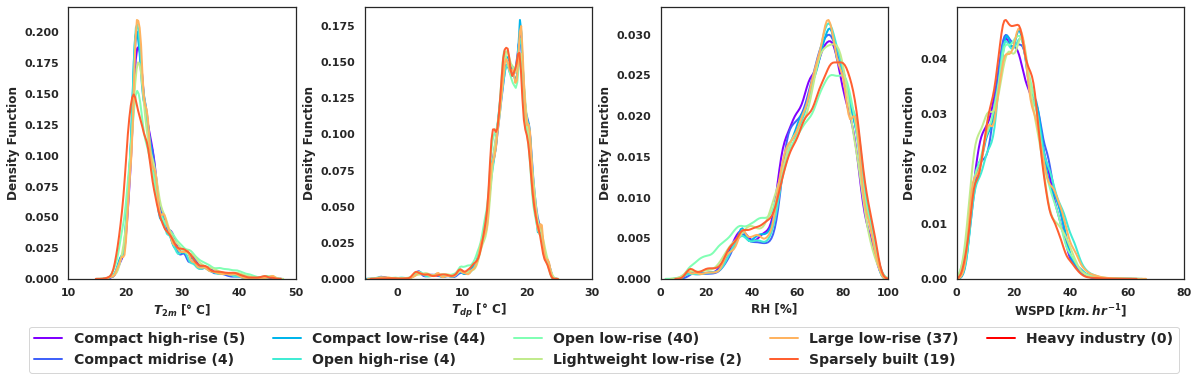

In [11]:
c = np.where(np.logical_or(slon<280, slon>290))
madatac = np.empty(tsdata.shape)
madatac[:,:,:] = tsdata
madatac[:,:,list(c[0])] = np.nan
figurename = 'KDE_LCZs_Sydney_CBD_coastal.png' 
plot_kde(madatac,vlabels,lind,LCZnm,figurename,mx,mn)

#### Plot LCZ distributions inland Sydney west of the CBD

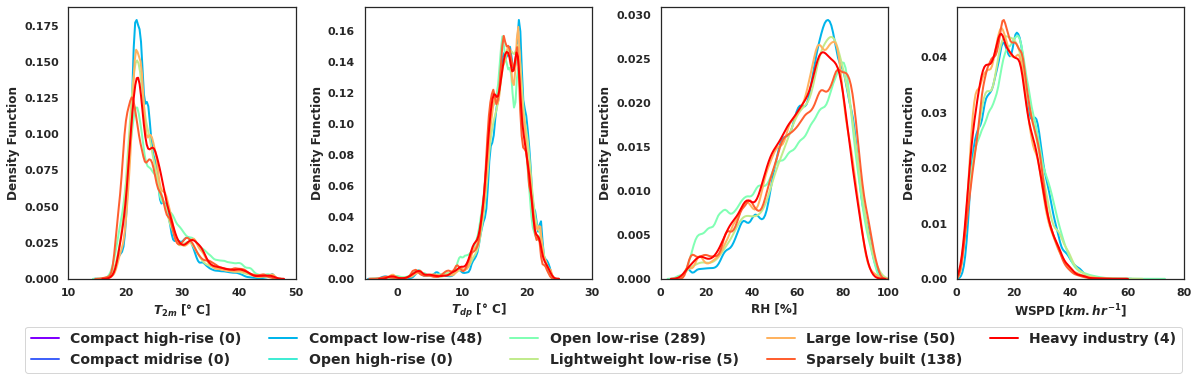

In [12]:
w = np.where(np.logical_or(slon<255, slon>280))
madataw = np.empty(tsdata.shape)
madataw[:,:,:] = tsdata
madataw[:,:,list(w[0])] = np.nan
figurename = 'KDE_LCZs_Sydney_west_of_CBD.png' 
plot_kde(madataw,vlabels,lind,LCZnm,figurename,mx,mn)

#### Plot LCZ distributions western Sydney to rural transition

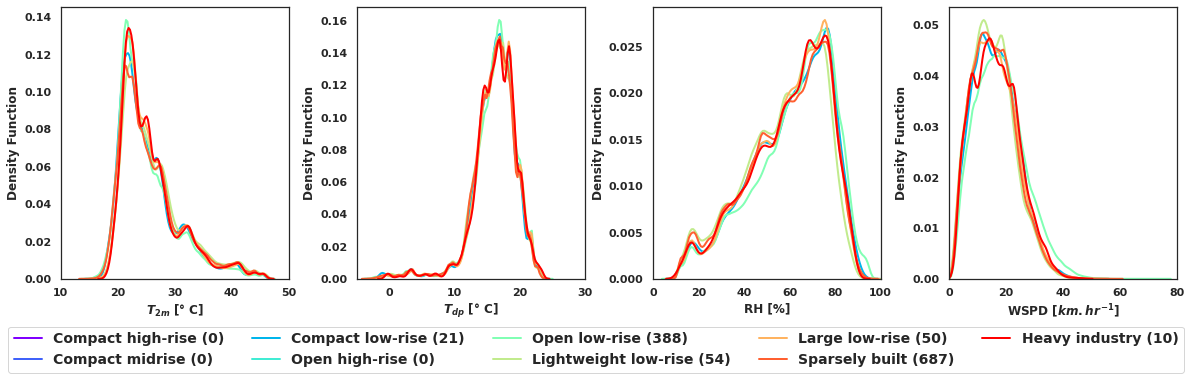

In [13]:
r = np.where(np.logical_or(slon<210, slon>255))
madatar = np.empty(tsdata.shape)
madatar[:,:,:] = tsdata
madatar[:,:,list(r[0])] = np.nan
figurename = 'KDE_LCZs_Sydney_West_to_Rural.png' 
plot_kde(madatar,vlabels,lind,LCZnm,figurename,mx,mn)

### Split analysis between day and night

Note that WRF times are in UTC so we need to add +10 to get local time

In [14]:
start = dt.datetime(syear,smon,sday,0,0,0)
end = dt.datetime(eyear,emon,eday,0,0,0)
days = (end - start).days
ntim = days * 24 * 60
datelist = [start + dt.timedelta(minutes=x) for x in range(ntim+1)]
# Get the day-month hour-minutes on 10 minute interval
ftimes = np.asarray([datelist[x].strftime("%m-%d %H-%M") for x in range(ntim+1)])[::10]
fhours = np.asarray([datelist[x].strftime("%H") for x in range(ntim+1)])[::10]
dayhours = np.asarray([np.int(fhours[x]) for x in range(len(fhours))])
nighthours = np.asarray([np.int(fhours[x]) for x in range(len(fhours))])
# For UTC+10 6am is 20UTC and 6pm is 08UTC
dayhours[(dayhours>8) & (dayhours<20)]=-99
nighthours[(nighthours<8)]=-99
nighthours[(nighthours>20)]=-99
dayind = [i for i, n in enumerate(dayhours) if n > -1]
nightind = [i for i, n in enumerate(nighthours) if n > -1]

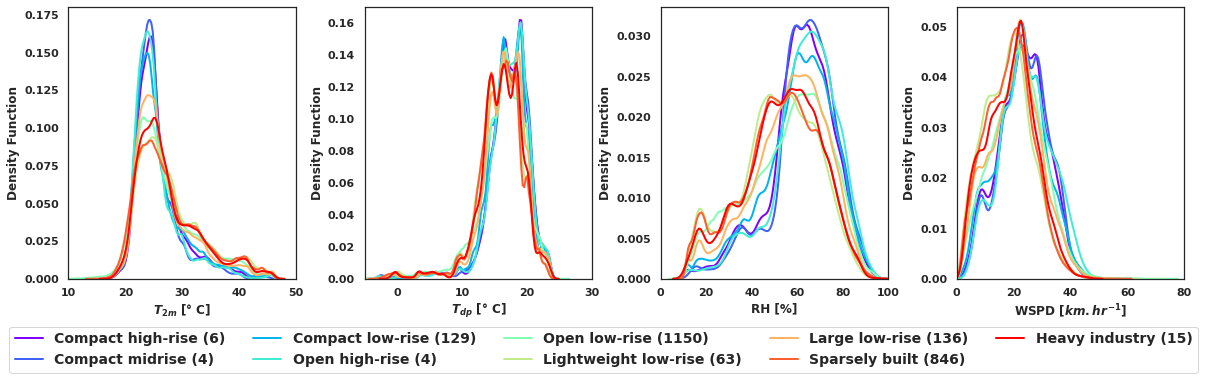

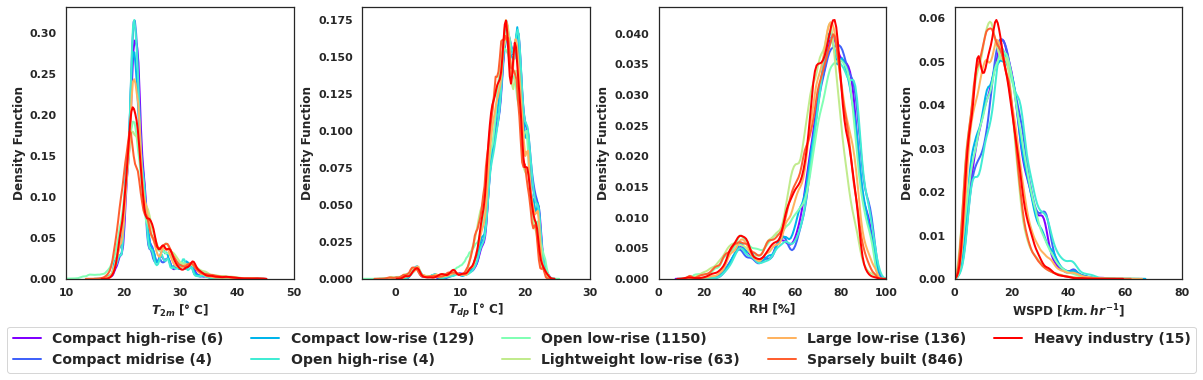

In [15]:
figurename = 'KDE_LCZs_Sydney_All_DAYTIME.png' 
plot_kde(tsdata[:,dayind[:-1],:],vlabels,lind,LCZnm,figurename,mx,mn)
figurename = 'KDE_LCZs_Sydney_All_NIGHTTIME.png' 
plot_kde(tsdata[:,nightind[:-1],:],vlabels,lind,LCZnm,figurename,mx,mn)

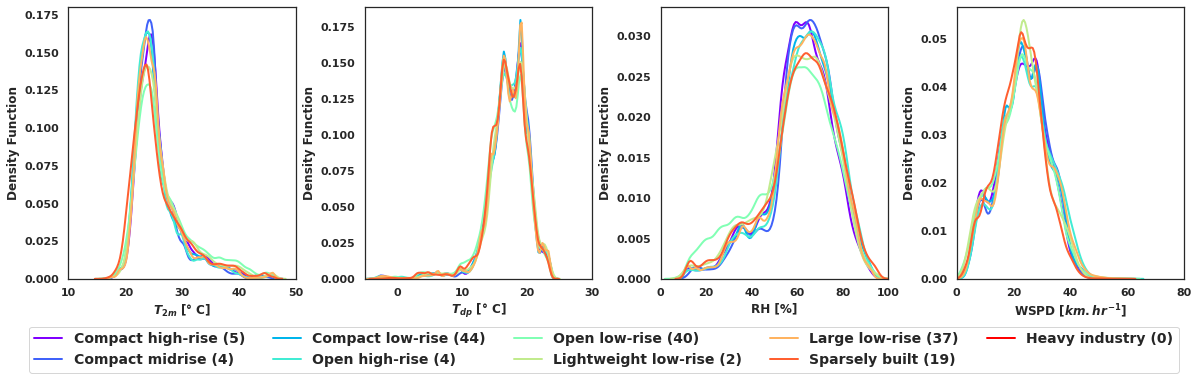

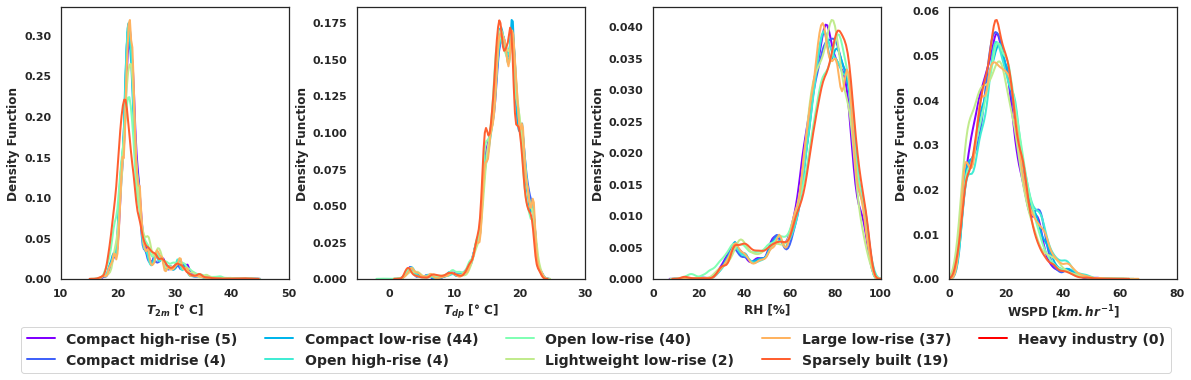

In [16]:
figurename = 'KDE_LCZs_Sydney_CBD_coastal_DAYTIME.png' 
plot_kde(madatac[:,dayind[:-1],:],vlabels,lind,LCZnm,figurename,mx,mn)
figurename = 'KDE_LCZs_Sydney_CBD_coastal_NIGHTTIME.png' 
plot_kde(madatac[:,nightind[:-1],:],vlabels,lind,LCZnm,figurename,mx,mn)

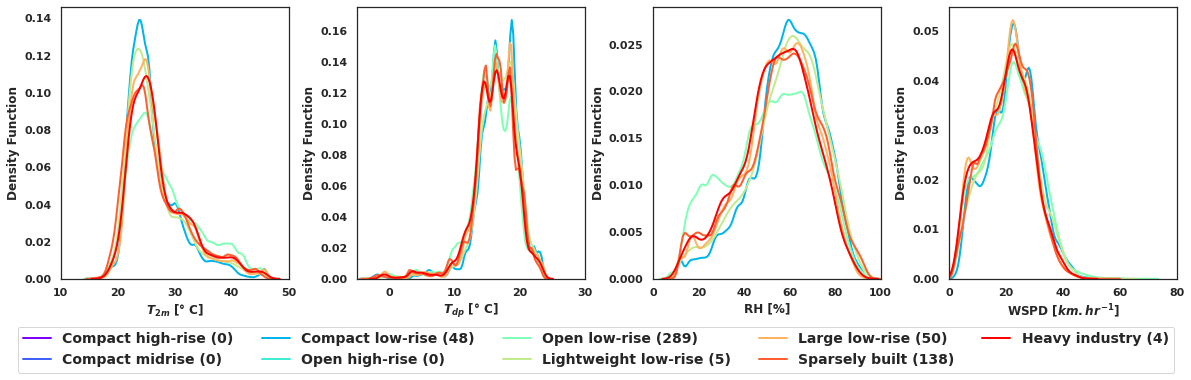

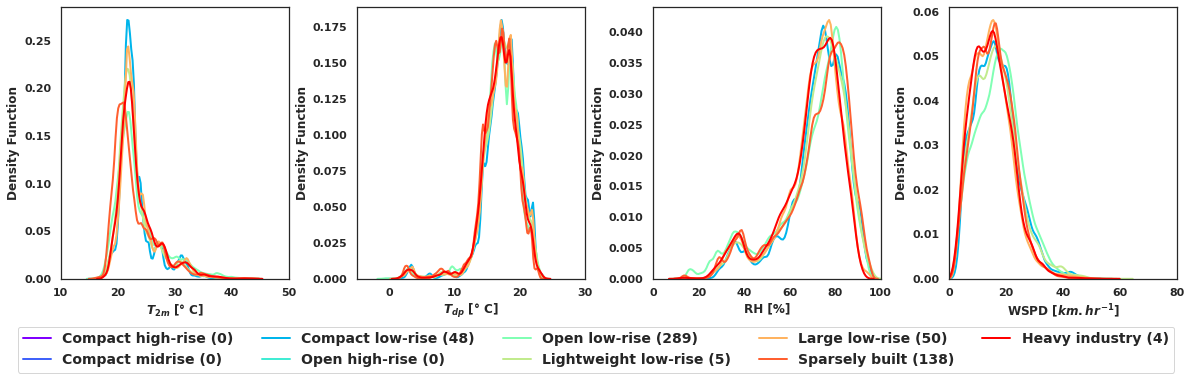

In [17]:
figurename = 'KDE_LCZs_Sydney_west_of_CBD_DAYTIME.png' 
plot_kde(madataw[:,dayind[:-1],:],vlabels,lind,LCZnm,figurename,mx,mn)
figurename = 'KDE_LCZs_Sydney_west_of_CBD_NIGHTTIME.png' 
plot_kde(madataw[:,nightind[:-1],:],vlabels,lind,LCZnm,figurename,mx,mn)

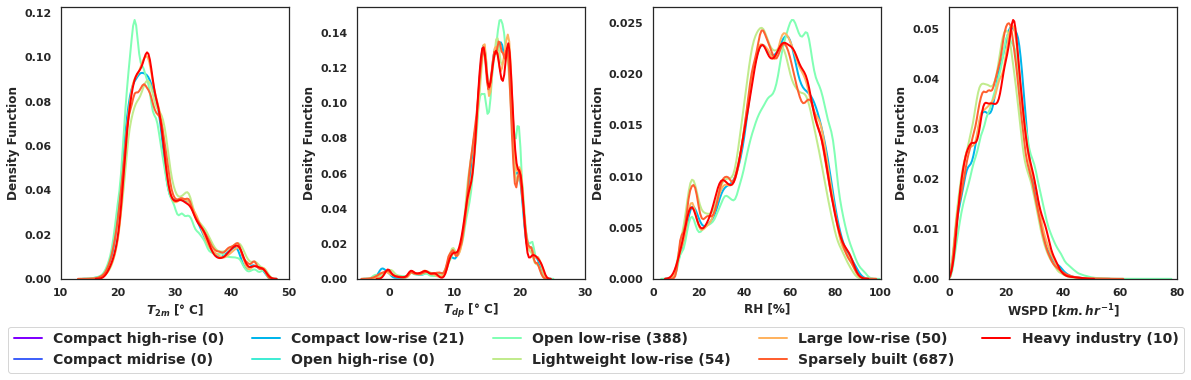

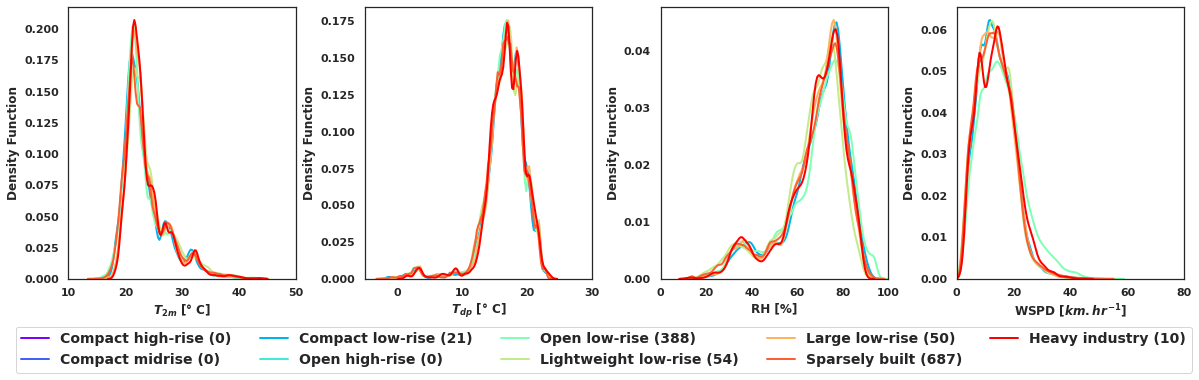

In [18]:
figurename = 'KDE_LCZs_Sydney_West_to_Rural_DAYTIME.png' 
plot_kde(madatar[:,dayind[:-1],:],vlabels,lind,LCZnm,figurename,mx,mn)
figurename = 'KDE_LCZs_Sydney_West_to_Rural_NIGHTTIME.png' 
plot_kde(madatar[:,nightind[:-1],:],vlabels,lind,LCZnm,figurename,mx,mn)

### Split analysis by heatwave periods

From the Bureau of Meteorology Special Climate Statement 61 there were 3 heatwaves:

    10-14 January
    17-21 January
    31 January - 12 February 
    
For the latter heatwave this was terminated by a cold front.

So here we examine separately the week before the first heatwave, each heatwave period and the week after the third heatwave

In [19]:
PRES = [i for i in range(len(ftimes)) if ftimes[i] in ['01-03 00-00']][0]
PREF = [i for i in range(len(ftimes)) if ftimes[i] in ['01-10 00-00']][0]

HW1S = [i for i in range(len(ftimes)) if ftimes[i] in ['01-10 00-00']][0]
HW1F = [i for i in range(len(ftimes)) if ftimes[i] in ['01-15 00-00']][0]

HW2S = [i for i in range(len(ftimes)) if ftimes[i] in ['01-17 00-00']][0]
HW2F = [i for i in range(len(ftimes)) if ftimes[i] in ['01-22 00-00']][0]

HW3S = [i for i in range(len(ftimes)) if ftimes[i] in ['01-31 00-00']][0]
HW3F = [i for i in range(len(ftimes)) if ftimes[i] in ['02-13 00-00']][0]

POSTS = [i for i in range(len(ftimes)) if ftimes[i] in ['02-13 00-00']][0]
POSTF = [i for i in range(len(ftimes)) if ftimes[i] in ['02-20 00-00']][0]


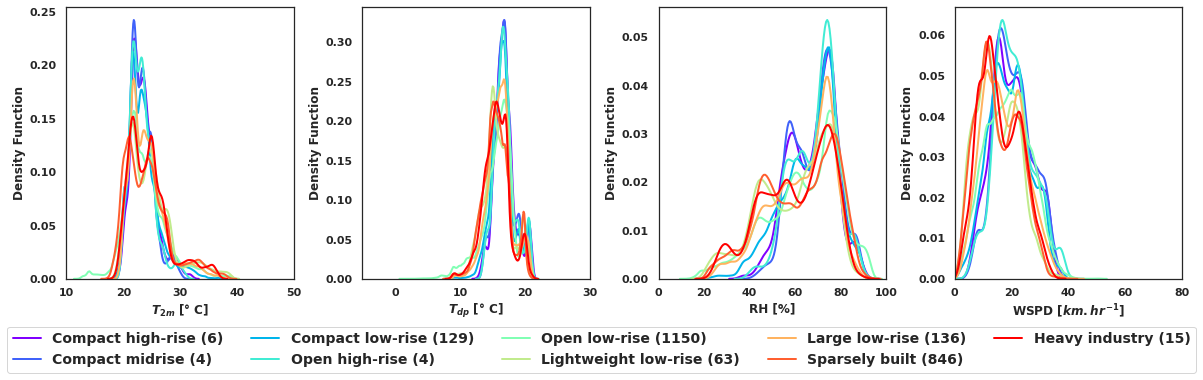

In [20]:
figurename = 'KDE_LCZs_Sydney_All_preHW1.png' 
plot_kde(tsdata[:,PRES:PREF,:],vlabels,lind,LCZnm,figurename,mx,mn)

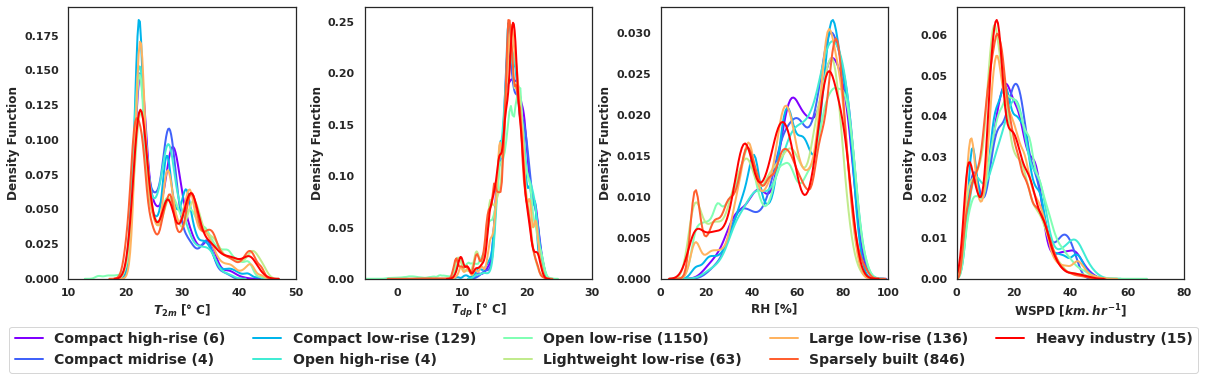

In [21]:
figurename = 'KDE_LCZs_Sydney_All_HW1.png' 
plot_kde(tsdata[:,HW1S:HW1F,:],vlabels,lind,LCZnm,figurename,mx,mn)

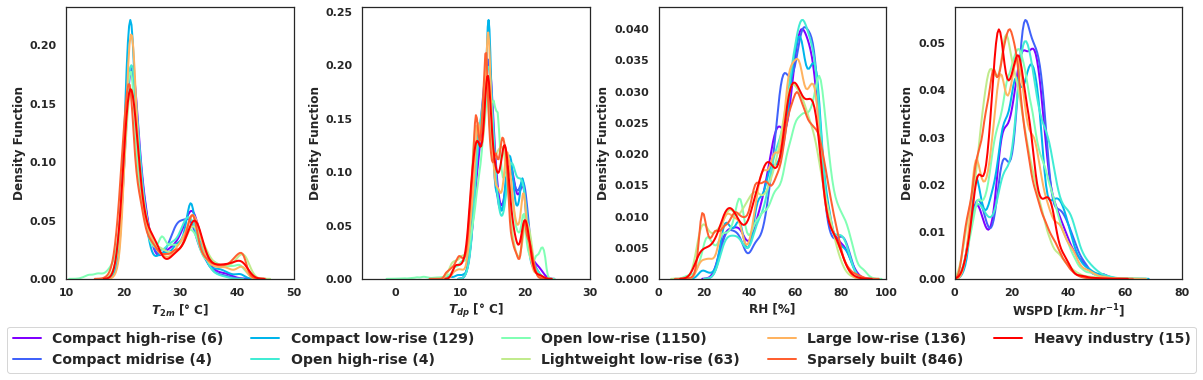

In [22]:
figurename = 'KDE_LCZs_Sydney_All_HW2.png' 
plot_kde(tsdata[:,HW2S:HW2F,:],vlabels,lind,LCZnm,figurename,mx,mn)

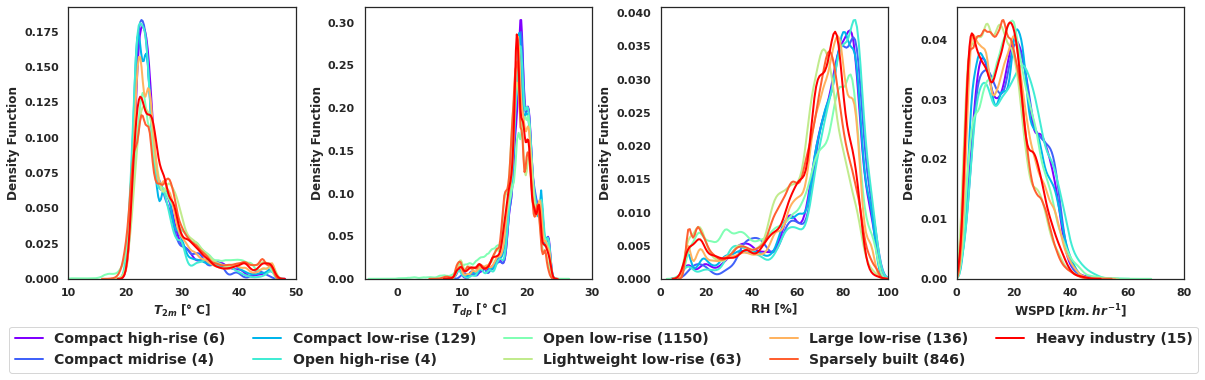

In [23]:
figurename = 'KDE_LCZs_Sydney_All_HW3.png' 
plot_kde(tsdata[:,HW3S:HW3F,:],vlabels,lind,LCZnm,figurename,mx,mn)

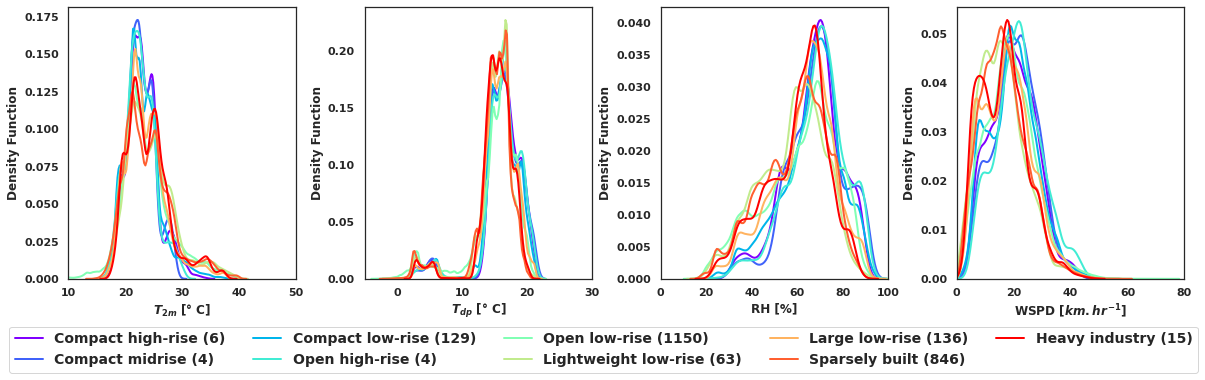

In [24]:
figurename = 'KDE_LCZs_Sydney_All_postHW3.png' 
plot_kde(tsdata[:,POSTS:POSTF,:],vlabels,lind,LCZnm,figurename,mx,mn)

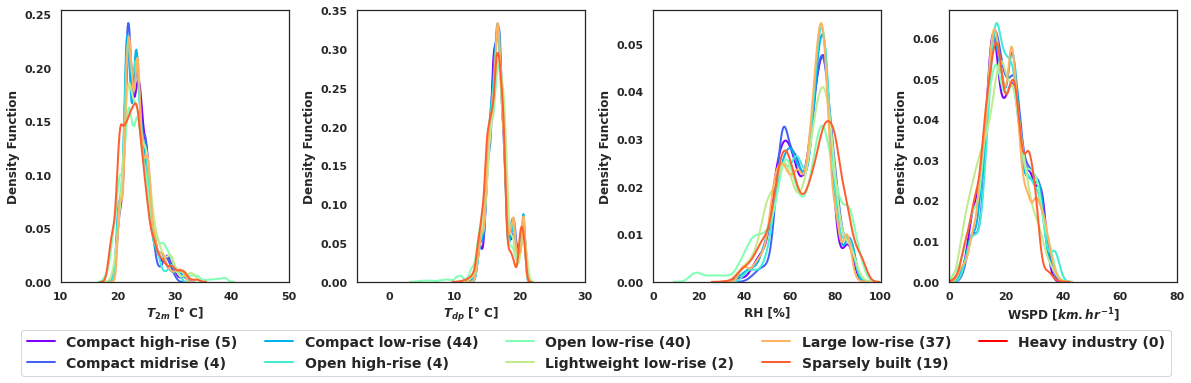

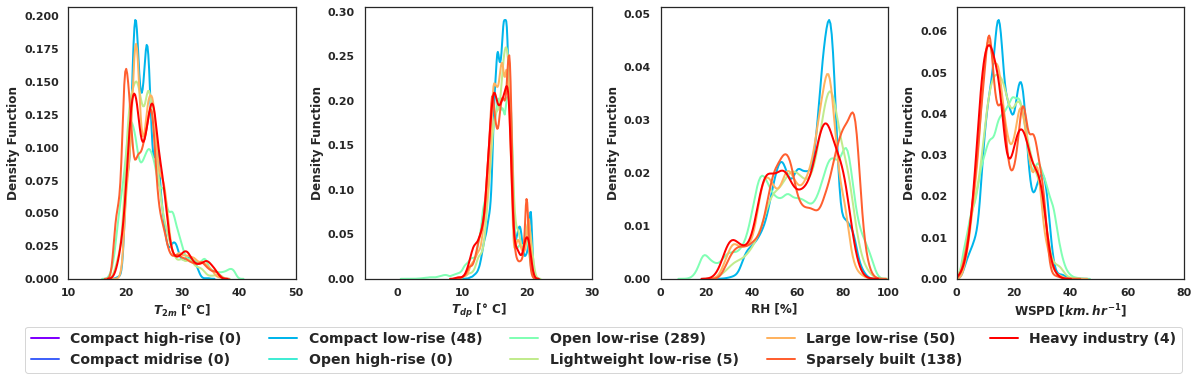

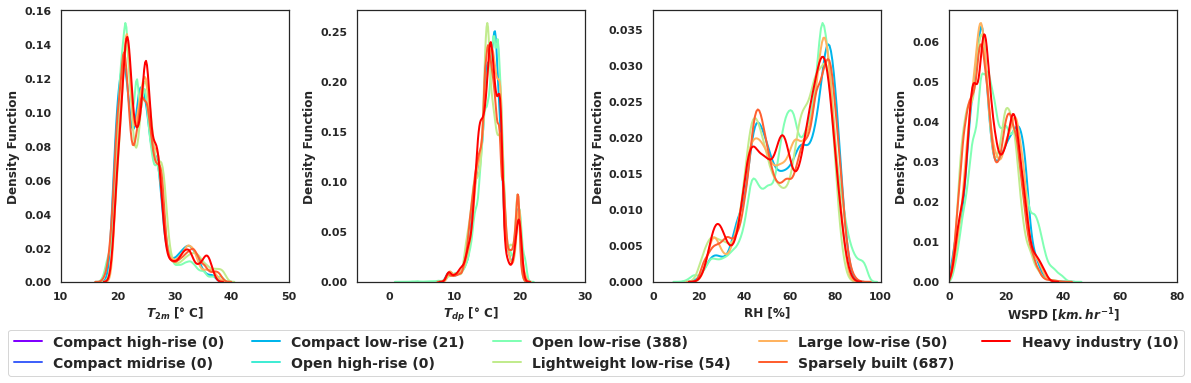

In [25]:
figurename = 'KDE_LCZs_Sydney_CBD_coastal_preHW.png' 
plot_kde(madatac[:,PRES:PREF,:],vlabels,lind,LCZnm,figurename,mx,mn)
figurename = 'KDE_LCZs_Sydney_west_of_CBD_preHW.png' 
plot_kde(madataw[:,PRES:PREF,:],vlabels,lind,LCZnm,figurename,mx,mn)
figurename = 'KDE_LCZs_Sydney_West_to_Rural_preHW.png' 
plot_kde(madatar[:,PRES:PREF,:],vlabels,lind,LCZnm,figurename,mx,mn)

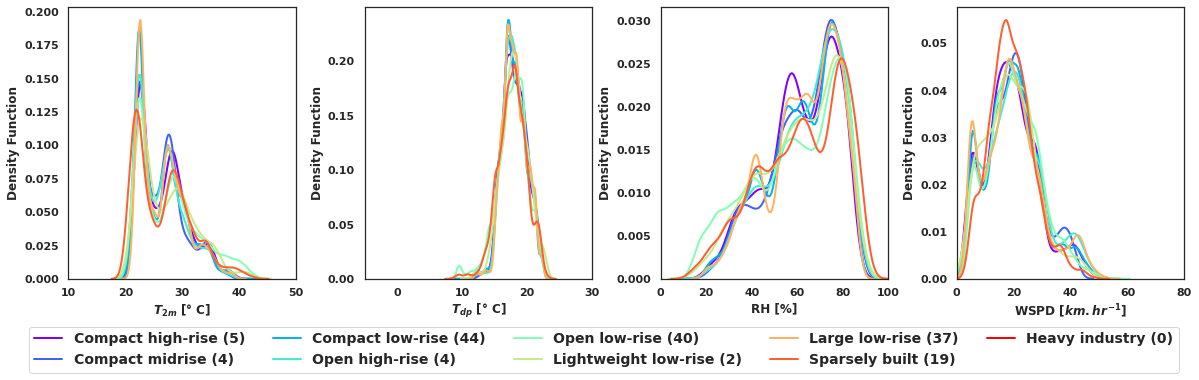

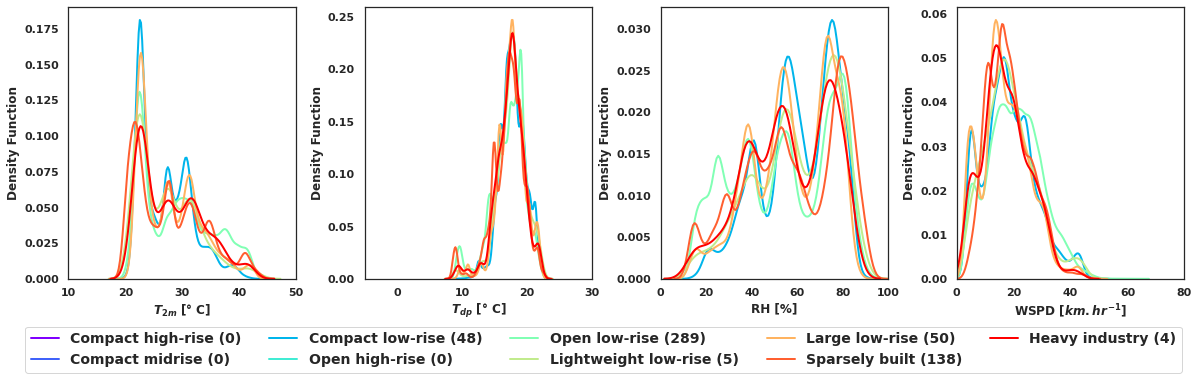

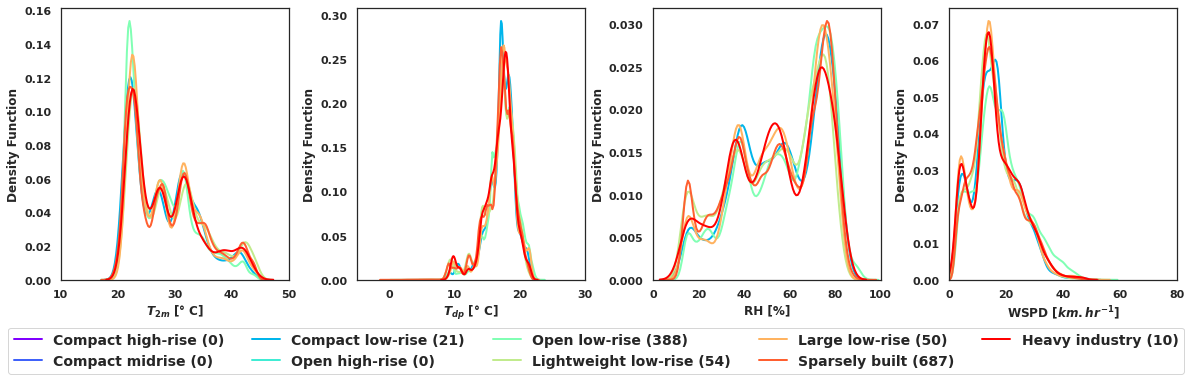

In [26]:
figurename = 'KDE_LCZs_Sydney_CBD_coastal_HW1.png' 
plot_kde(madatac[:,HW1S:HW1F,:],vlabels,lind,LCZnm,figurename,mx,mn)
figurename = 'KDE_LCZs_Sydney_west_of_CBD_HW1.png' 
plot_kde(madataw[:,HW1S:HW1F,:],vlabels,lind,LCZnm,figurename,mx,mn)
figurename = 'KDE_LCZs_Sydney_West_to_Rural_HW1.png' 
plot_kde(madatar[:,HW1S:HW1F,:],vlabels,lind,LCZnm,figurename,mx,mn)

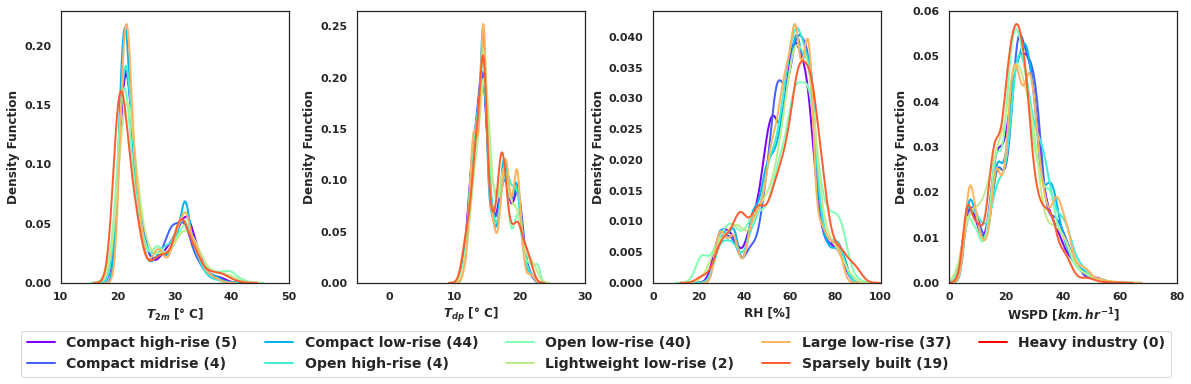

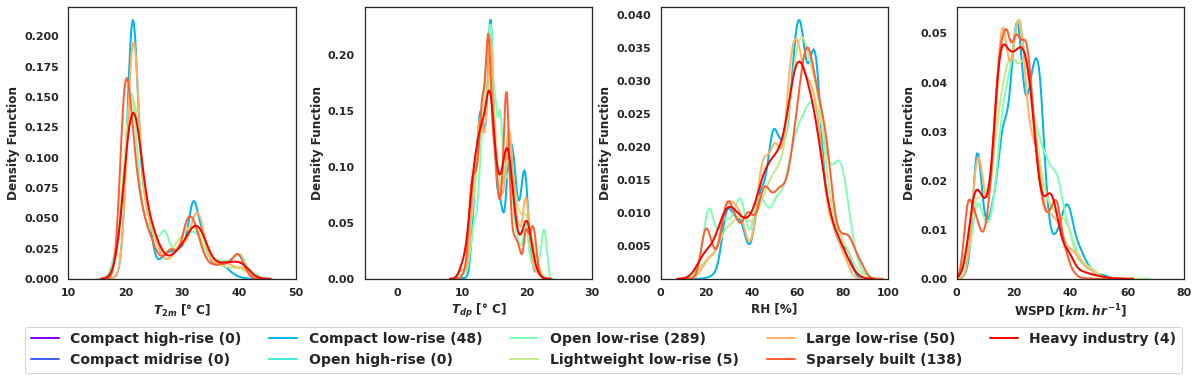

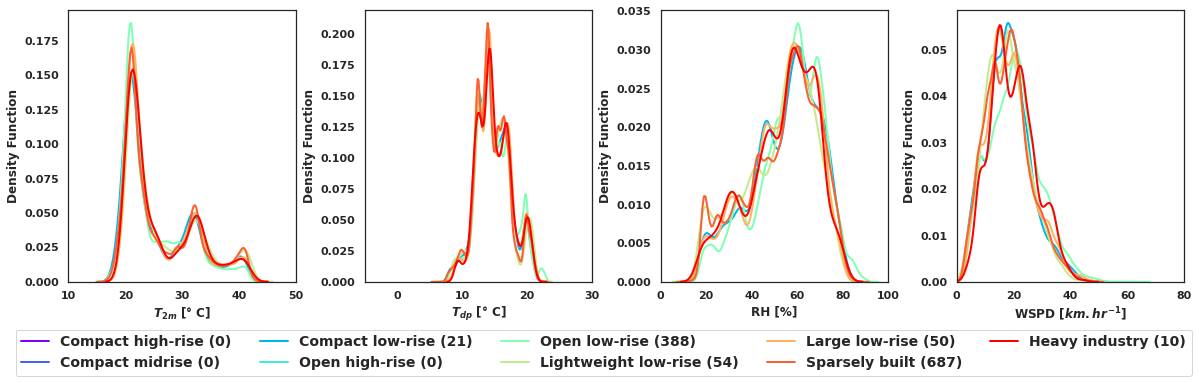

In [27]:
figurename = 'KDE_LCZs_Sydney_CBD_coastal_HW2.png' 
plot_kde(madatac[:,HW2S:HW2F,:],vlabels,lind,LCZnm,figurename,mx,mn)
figurename = 'KDE_LCZs_Sydney_west_of_CBD_HW2.png' 
plot_kde(madataw[:,HW2S:HW2F,:],vlabels,lind,LCZnm,figurename,mx,mn)
figurename = 'KDE_LCZs_Sydney_West_to_Rural_HW2.png' 
plot_kde(madatar[:,HW2S:HW2F,:],vlabels,lind,LCZnm,figurename,mx,mn)

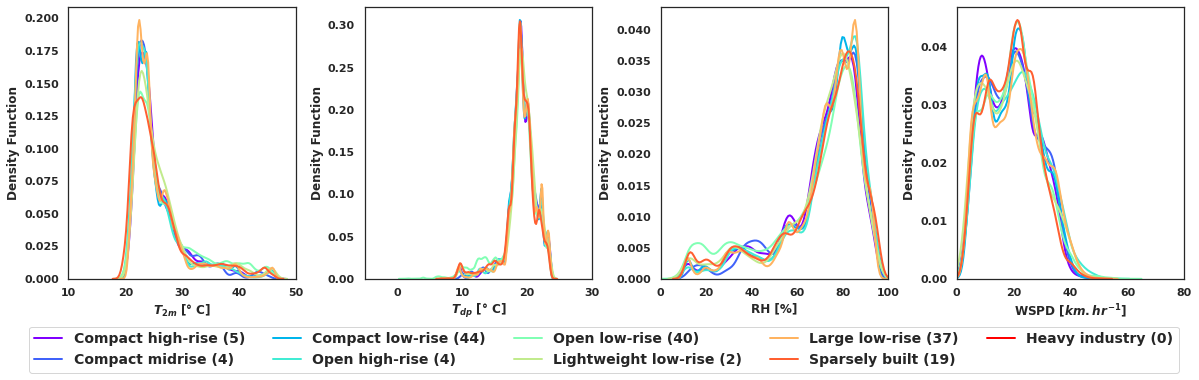

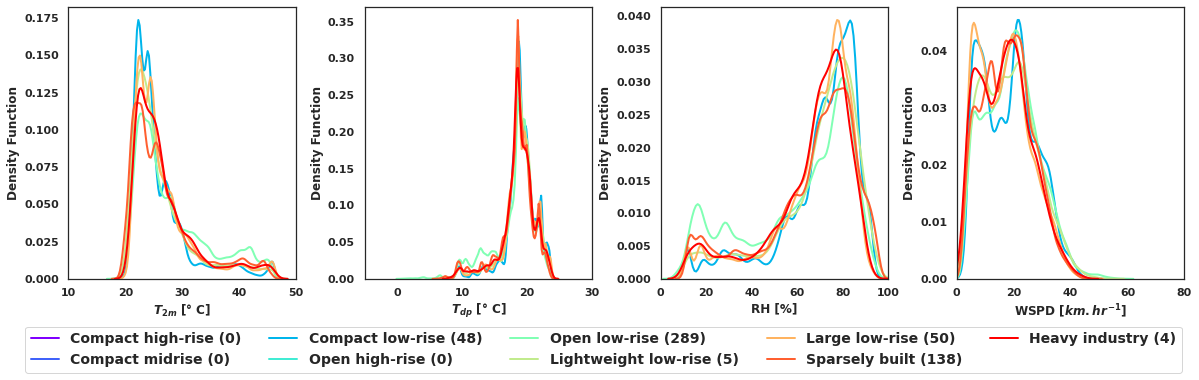

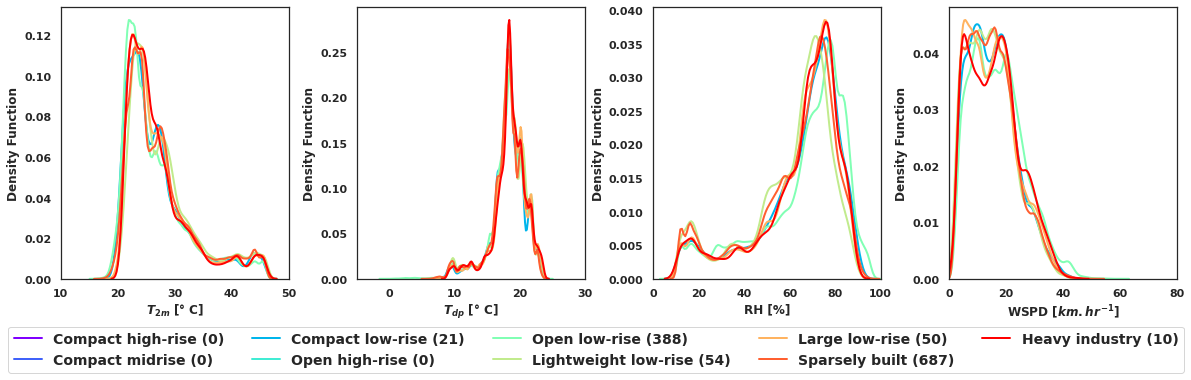

In [28]:
figurename = 'KDE_LCZs_Sydney_CBD_coastal_HW3.png' 
plot_kde(madatac[:,HW3S:HW3F,:],vlabels,lind,LCZnm,figurename,mx,mn)
figurename = 'KDE_LCZs_Sydney_west_of_CBD_HW3.png' 
plot_kde(madataw[:,HW3S:HW3F,:],vlabels,lind,LCZnm,figurename,mx,mn)
figurename = 'KDE_LCZs_Sydney_West_to_Rural_HW3.png' 
plot_kde(madatar[:,HW3S:HW3F,:],vlabels,lind,LCZnm,figurename,mx,mn)

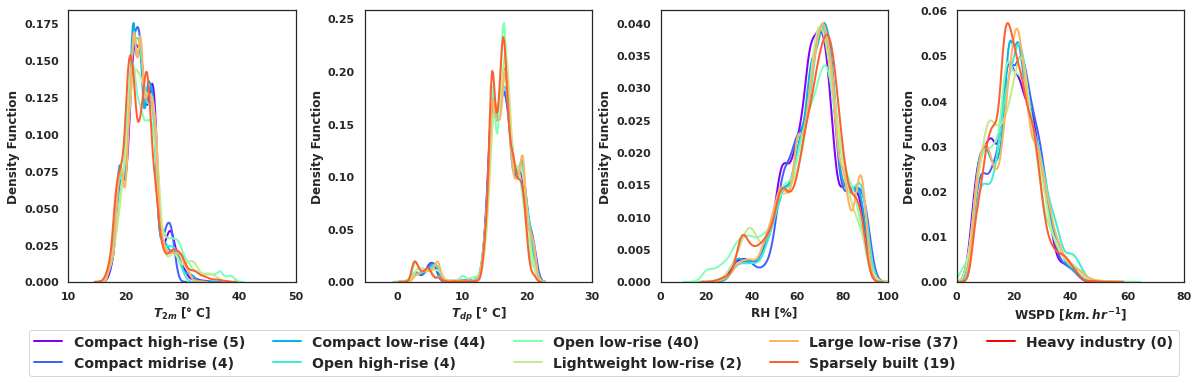

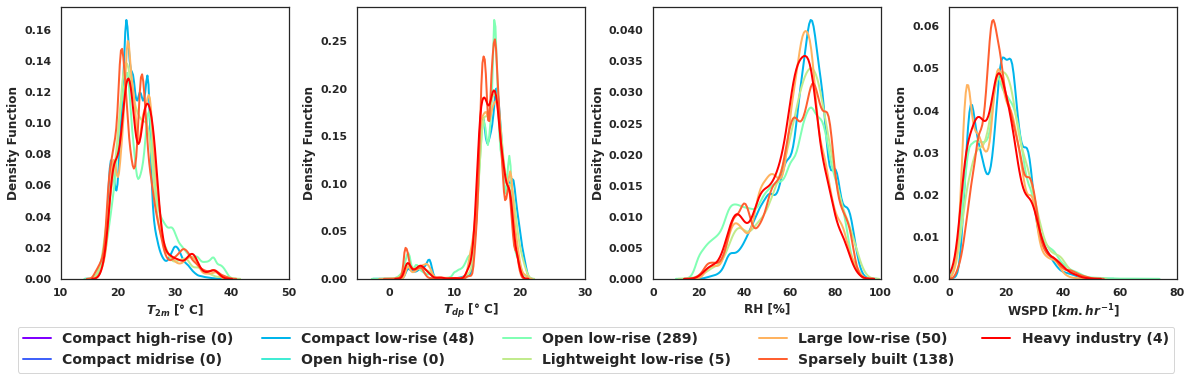

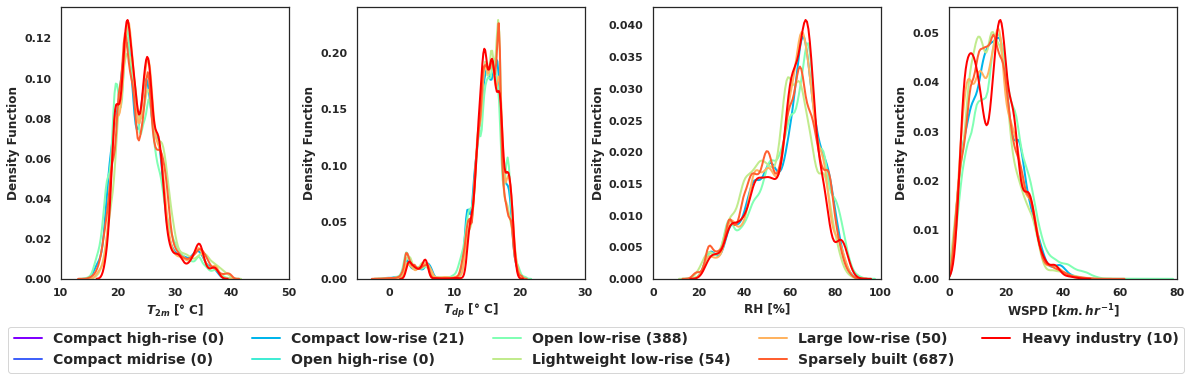

In [29]:
figurename = 'KDE_LCZs_Sydney_CBD_coastal_postHW.png' 
plot_kde(madatac[:,POSTS:POSTF,:],vlabels,lind,LCZnm,figurename,mx,mn)
figurename = 'KDE_LCZs_Sydney_west_of_CBD_postHW.png' 
plot_kde(madataw[:,POSTS:POSTF,:],vlabels,lind,LCZnm,figurename,mx,mn)
figurename = 'KDE_LCZs_Sydney_West_to_Rural_postHW.png' 
plot_kde(madatar[:,POSTS:POSTF,:],vlabels,lind,LCZnm,figurename,mx,mn)

## Compare the effect of each LCZ per time of day

In [9]:
hours = np.asarray([np.int(fhours[x]) for x in range(len(fhours)-1)])
ueffect = tsdata - gdata

In [10]:
# Function to plot data
def plot_hist(mdata,vlabels,luind,hours,LCZnm,figurename):
    """This function plots separate panels for each model 
    """
    import seaborn as sns; sns.set(style="white", color_codes=True)
    import string

    # Define dimensions
    nLCZ = len(luind)
    nvar = mdata.shape[0]
    npts = mdata.shape[1]
      
    # Create figure object and subplots
    fig, ax = plt.subplots(4, 1, figsize=(20,20), squeeze=False)
    
    plt.rcParams['savefig.dpi'] = 500
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["axes.titleweight"] = "bold"
    plt.rcParams["axes.titlepad"] = -12.0
    
    # Define the line styles and colors for the datasets
    evenly_spaced_interval = np.linspace(0, 1, nLCZ)
    mycolors = [plt.cm.rainbow(x) for x in evenly_spaced_interval]
    
    
    # Loop through the variables
    for vv in range(nvar):        

        xpos = 0
        
        # Loop through the time of day
        for tt in [14,15,16,17,18,19,20,21,22,23,0,1,2,3,4,5,6,7,8,9,10,11,12,13]:
            
            tind = [i for i, n in enumerate(hours) if n == tt]
        
            # Loop through the LCZs
            for ll in range(nLCZ):
                if ll == 0:
                    tmpdata = mdata[vv,tind,:luind[ll]]
                elif ll == nLCZ-1:
                    tmpdata = mdata[vv,tind,luind[ll-1]:]
                else:
                    tmpdata = mdata[vv,tind,luind[ll-1]:luind[ll]]
                    
                if tt == 14:
                    ax[vv,0].plot([xpos,xpos],[np.nanpercentile(tmpdata,25),np.nanpercentile(tmpdata,75)], 
                      linewidth=5,color=mycolors[ll], linestyle='-',label=LCZnm[ll])
                else:
                    ax[vv,0].plot([xpos,xpos],[np.nanpercentile(tmpdata,25),np.nanpercentile(tmpdata,75)], 
                              linewidth=5,color=mycolors[ll], linestyle='-')
                del tmpdata
                
                if ll == 5:
                    if tt == 14:
                        xarr = xpos
                    else:
                        xarr = np.append(xarr,xpos)
                
                if ll == nLCZ-1:
                    xpos = xpos + 5
                else:
                    xpos = xpos + 1

        # Labelling of subplot panels
        ax[vv,0].set_title('(%s)' %(string.ascii_lowercase[vv]), fontweight='bold', fontsize=16, y = 0.95, x = 0.025)
        ax[vv,0].axhline(0, color='grey', linestyle='--',linewidth=2.0)
        ax[vv,0].set_ylabel('%s' %(vlabels[vv]), fontweight = 'bold')
        if vv < nvar-1:
            ax[vv,0].set_xticks([],[])
        else:
            ax[vv,0].set_xticks(xarr)
            ax[vv,0].set_xticklabels(['00','01','02','03','04','05','06','07','08','09','10','11',
                                     '12','13','14','15','16','17','18','19','20','21','22','23'],fontsize=14, fontweight = 'bold')
            ax[vv,0].set_xlabel("Hour of Day")

    legend = ax[-1,0].legend(loc='upper center', bbox_to_anchor=(0.5,-0.15), ncol=4, fontsize=14)
    fig.subplots_adjust(wspace=0.30, hspace=0.1)
    fig.savefig(figurename,bbox_extra_artists=(legend,), bbox_inches='tight')
#    plt.close(fig)


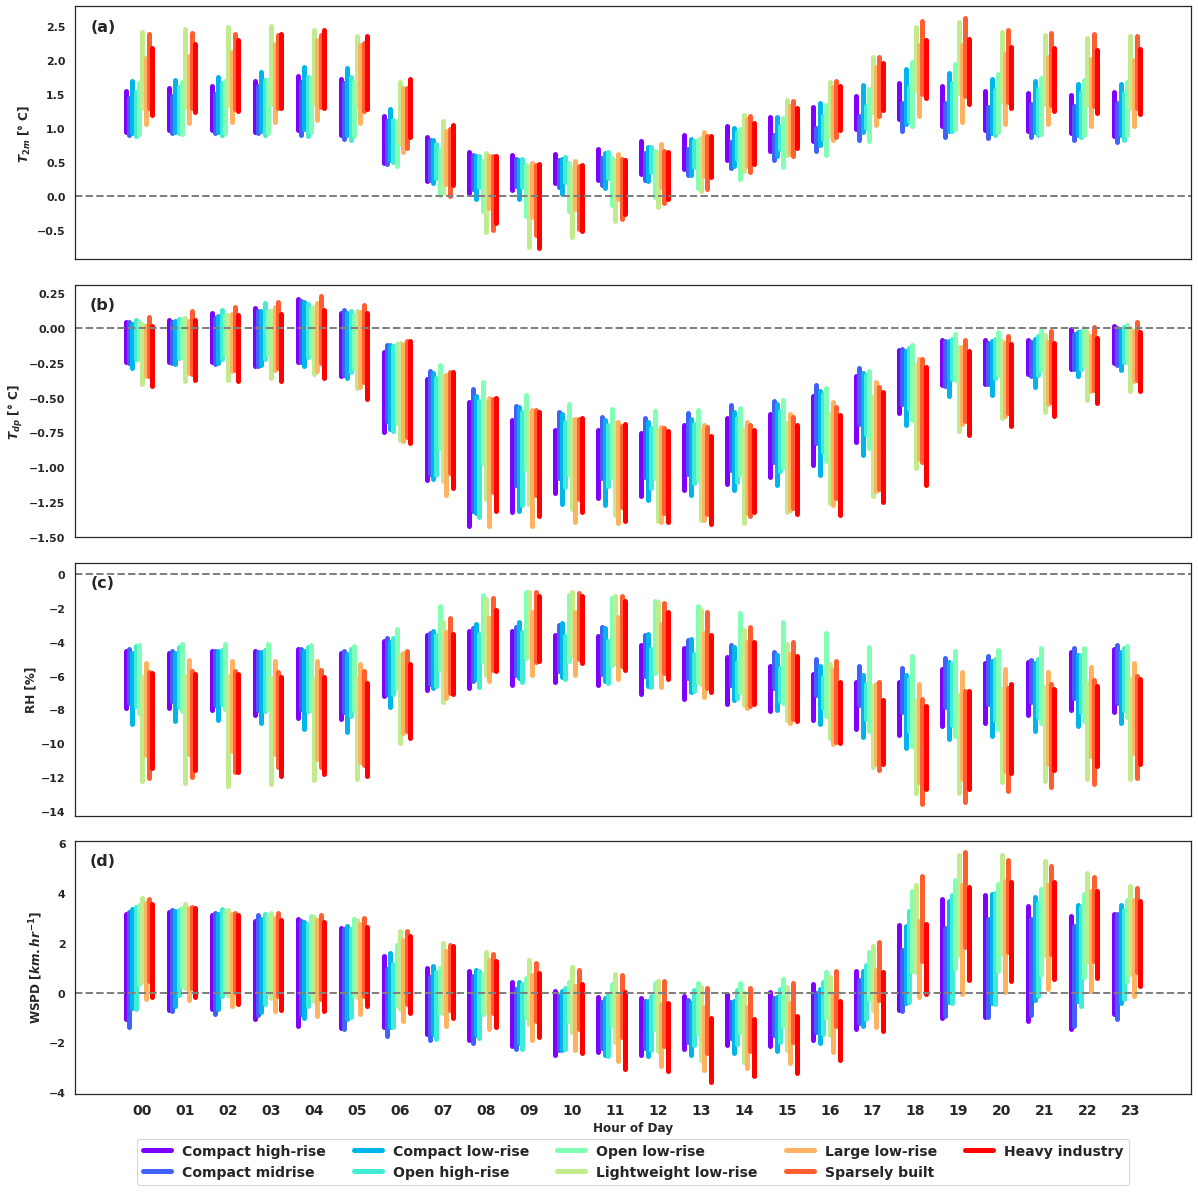

In [21]:
lind = [6,10,139,143,1293,1356,1492,2338,2353]
vlabels = ['$T_{2m}$ [\xb0 C]','$T_{dp}$ [\xb0 C]', 'RH [%]','WSPD [$km.hr^{-1}$]']
figurename = 'HIST_LCZs_Effect_IQR_Time_of_Day.png' 
plot_hist(ueffect,vlabels,lind,hours,LCZnm,figurename)

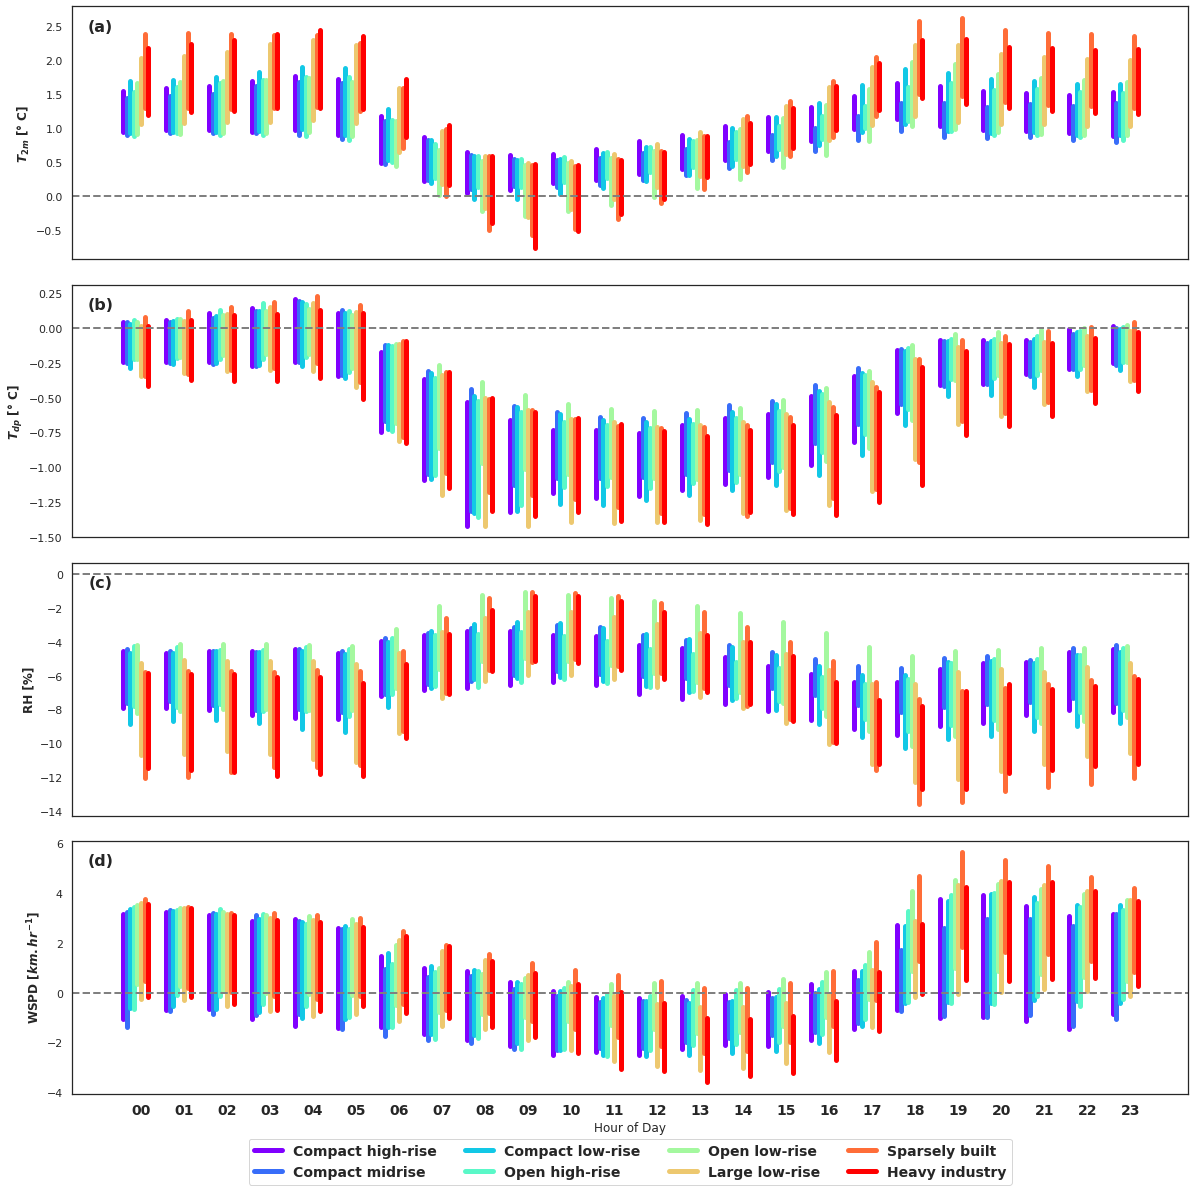

In [11]:
lind = [6,10,139,143,1293,1429,2275,2290]
ueffsub = np.empty((4,len(ftimes)-1,len(slat)-63),dtype=np.float64)
ueffsub[:,:,:1293] = ueffect[:,:,:1293]
ueffsub[:,:,1293:] = ueffect[:,:,1356:]
vlabels = ['$T_{2m}$ [\xb0 C]','$T_{dp}$ [\xb0 C]', 'RH [%]','WSPD [$km.hr^{-1}$]']
figurename = 'HIST_LCZs_Effect_IQR_Time_of_Day.png' 
plot_hist(ueffsub,vlabels,lind,hours,LCZnm,figurename)